In [18]:
import os
import sys
root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts'))
sys.path.append(root_path_scripts)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/visualize_simple_rag_pipe_line'))
sys.path.append(root_path_scripts)


root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/load_split_data'))
sys.path.append(root_path_scripts)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/simple_pipeline'))
sys.path.append(root_path_scripts)

In [19]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

# Unset the environment variables if they are set
if "OPENAI_API_KEY" in os.environ:
    del os.environ["OPENAI_API_KEY"]
if "MONGODB_URI" in os.environ:
    del os.environ["MONGODB_URI"]

# Load environment variables from the .env file and explicitly reload them
load_dotenv(override=True)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/load_split_data'))
sys.path.append(root_path_scripts)

root_path_scripts = os.path.abspath(os.path.join(os.getcwd(), '../scripts/simple_pipeline'))
sys.path.append(root_path_scripts)

from load_split import load_document, split_document
from simple_pipeline.retrieval import add_documents_to_vector_store
from generator import generate_response
from evaluator import load_evaluation_data, evaluate_responses, print_evaluation_results


In [23]:
import os
import umap
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv
from load_split_data.load_split import load_document, split_document
from visualize_simple_rag_pipe_line.retrieval import load_embeddings_from_db, query_relevant_documents, vector_store
from visualize_simple_rag_pipe_line.generator import generate_response
from pymongo import MongoClient
from pymongo.server_api import ServerApi
# Initialize embeddings model
from visualize_simple_rag_pipe_line.retrieval import embeddings_model


# Load environment variables from the .env file
load_dotenv(find_dotenv())

# Retrieve environment variables
db_uri = os.getenv("MONGODB_URI")

# Database configuration
client = MongoClient(db_uri, server_api=ServerApi('1'))

# Updated database and collection names
LizzyAI_ContractsDB = client["LizzyAI_Contracts"]
lizzyai_collection = LizzyAI_ContractsDB["contracts"]


In [22]:

# Load embeddings from MongoDB
embeddings, documents = load_embeddings_from_db(lizzyai_collection)

# UMAP transformation
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# Visualization of the dataset embeddings
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.6)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Dataset Emdeddings', fontsize=14)
plt.axis('off')
plt.show()


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


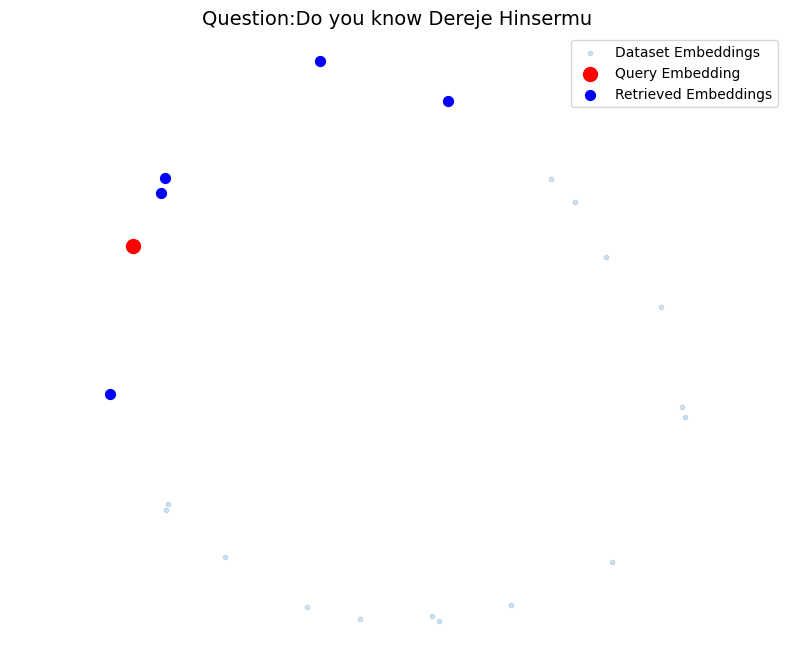

In [ ]:

# Example query
query_text = "Do you know Dereje Hinsermu"

# Retrieve documents
retrieved_documents = query_relevant_documents(query_text, vector_store)

# Function to print documents nicely
def word_wrap(text, width=80):
    return '\n'.join([text[i:i+width] for i in range(0, len(text), width)])

# # Print the retrieved documents
# for document in retrieved_documents:
#     print(word_wrap(document.page_content))
#     print('')

# Assuming embeddings are included in the documents retrieved
# For this example, let's assume the embeddings are part of the 'metadata' attribute
retrieved_embeddings = [doc.metadata['embedding'] for doc in retrieved_documents]


# Retrieve embeddings for visualization
query_embedding = embeddings_model.embed_query(query_text)

# Project query and retrieved embeddings
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# Visualization of the query and retrieved embeddings
plt.figure(figsize=(10, 8))
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, alpha=0.2, label='Dataset Embeddings')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=100, c='red', label='Query Embedding')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, c='blue', label='Retrieved Embeddings')
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'Question:{query_text}', fontsize=14)
plt.legend()
plt.axis('off')
plt.show()


## Q and A

In [25]:
# Generate a response
question = "Who owns the IP"
response = generate_response(question)
print(response['result'])

The Company owns all worldwide rights, titles, and interests in and to each item of Company Intellectual Property, except for Intellectual Property exclusively licensed to the Company pursuant to an Inbound IP Contract.
